In [2]:
%load_ext autoreload
%autoreload 2

from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader

import torch
from torch.utils.data import Dataset
import torch.distributions as D

from propose.models.flows import CondGraphFlow

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from propose.training.trainers import supervised_trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single Point

In [30]:
class SinglePointDataset(Dataset):
    def __init__(self, length=100, prior=None):
        if prior is None:
            prior = D.MultivariateNormal(torch.zeros(3), torch.eye(3))

        data_list = []

        for i in range(length):
            data = HeteroData()
            data['x'].x = prior.sample((1, ))
            data['c'].x = data['x'].x[..., :2]

            data['c', '->', 'x'].edge_index = torch.LongTensor([[0, 0]]).T
            data_list.append(data)

        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def metadata(self):
        return self.data[0].metadata()

## Simple Prior
Standard Normal prior

In [31]:
dataset = SinglePointDataset(length=1000)
data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

In [32]:
epochs = 100
lr = 0.001
weight_decay = 1e-5

flow = CondGraphFlow(num_layers=10)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)


In [33]:
supervised_trainer(data_loader, flow, optimizer, epochs=epochs)

Epoch: 1/100 | RegPriorLoss 4.2823 | RegPosteriorLoss 2.7924 | Batch: 100%|██████████| 10/10 [00:01<00:00,  9.75it/s]
Epoch: 2/100 | RegPriorLoss 4.4186 | RegPosteriorLoss 2.4063 | Batch: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s]
Epoch: 3/100 | RegPriorLoss 4.2078 | RegPosteriorLoss 1.8574 | Batch: 100%|██████████| 10/10 [00:00<00:00, 10.04it/s]
Epoch: 4/100 | RegPriorLoss 4.6054 | RegPosteriorLoss 1.6267 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.68it/s]
Epoch: 5/100 | RegPriorLoss 4.4696 | RegPosteriorLoss 1.2385 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s]
Epoch: 6/100 | RegPriorLoss 4.2316 | RegPosteriorLoss 0.9604 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.39it/s]
Epoch: 7/100 | RegPriorLoss 4.2464 | RegPosteriorLoss 1.0839 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.12it/s]
Epoch: 8/100 | RegPriorLoss 4.4352 | RegPosteriorLoss 0.5967 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.54it/s]
Epoch: 9/100 | RegPriorLoss 4.4291 | RegPosteriorLoss 0.

In [34]:
posterior_data = HeteroData({
    'x': {'x': torch.Tensor([[0, 0, 0]]), 'batch': torch.Tensor([0])},
    'c': {'x': torch.Tensor([[1, 1]])},
    ('c', '->', 'x'): {'edge_index': torch.LongTensor([[0, 0]]).T}
})

prior_data = HeteroData({
    'x': {'x': torch.Tensor([[0, 0, 0]]), 'batch': torch.Tensor([0])},
})

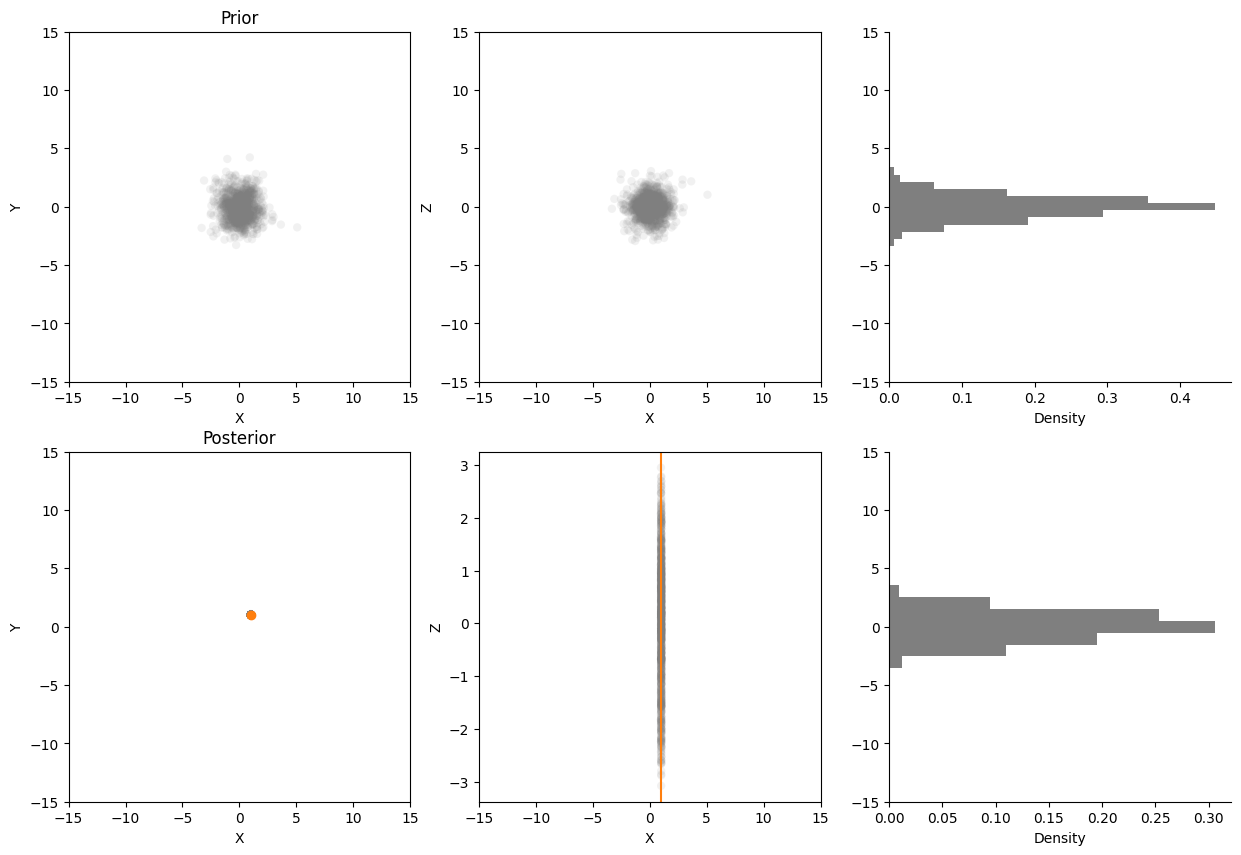

In [36]:
M_prior = flow.sample(1000, prior_data)['x']['x'].detach()
M_posterior = flow.sample(1000, posterior_data)['x']['x'].detach()

plt.style.use('default')
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].scatter(M_prior[..., 0], M_prior[..., 1], c='tab:gray', alpha=0.1, edgecolor='none')
axs[0, 0].set_xlim(-15, 15)
axs[0, 0].set_ylim(-15, 15)
axs[0, 0].set_title('Prior')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')

axs[0, 1].scatter(M_prior[..., 0], M_prior[..., 2], c='tab:gray', alpha=0.1, edgecolor='none')
axs[0, 1].set_xlim(-15, 15)
axs[0, 1].set_ylim(-15, 15)
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Z')

axs[1, 0].scatter(M_posterior[..., 0], M_posterior[..., 1], c='tab:gray', alpha=0.1, edgecolor='none')
axs[1, 0].scatter([1], [1], c='tab:orange')
axs[1, 0].set_xlim(-15, 15)
axs[1, 0].set_ylim(-15, 15)
axs[1, 0].set_title('Posterior')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')

axs[1, 1].scatter(M_posterior[..., 0], M_posterior[..., 2], c='tab:gray', alpha=0.1, edgecolor='none')
axs[1, 1].axvline(1, c='tab:orange')
axs[1, 1].set_xlim(-15, 15)
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Z')

axs[1, 2].hist(M_posterior[..., 2].detach(), bins=np.linspace(-25, 25, 50), orientation='horizontal', density=True, color='tab:gray')
axs[1, 2].set_ylim(-15, 15)
axs[1, 2].set_xlabel('Density')
sns.despine(ax=axs[1, 2])

axs[0, 2].hist(M_prior[..., 2].detach(), bins=np.linspace(-15, 15, 50), orientation='horizontal', density=True, color='tab:gray')
axs[0, 2].set_ylim(-15, 15)
axs[0, 2].set_xlabel('Density')
sns.despine(ax=axs[0, 2])

## Bimodal Prior

In [37]:
prior = D.mixture_same_family.MixtureSameFamily(
            D.Categorical(torch.ones(2)),
            D.MultivariateNormal(torch.Tensor([[0, 0, 10], [0, 0, -10]]), covariance_matrix=torch.stack((torch.eye(3), torch.eye(3))))
        )
dataset = SinglePointDataset(length=1000, prior=prior)
data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

In [38]:
epochs = 100
lr = 0.001
weight_decay = 1e-5

flow = CondGraphFlow(num_layers=10)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)

In [39]:
supervised_trainer(data_loader, flow, optimizer, epochs=epochs)


Epoch: 1/100 | RegPriorLoss 6.5163 | RegPosteriorLoss 4.9600 | Batch: 100%|██████████| 10/10 [00:01<00:00,  9.94it/s]
Epoch: 2/100 | RegPriorLoss 7.1435 | RegPosteriorLoss 4.2806 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.61it/s]
Epoch: 3/100 | RegPriorLoss 6.8235 | RegPosteriorLoss 3.9417 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.58it/s]
Epoch: 4/100 | RegPriorLoss 6.6613 | RegPosteriorLoss 3.5843 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.39it/s]
Epoch: 5/100 | RegPriorLoss 6.6229 | RegPosteriorLoss 3.4488 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.24it/s]
Epoch: 6/100 | RegPriorLoss 6.0514 | RegPosteriorLoss 3.0164 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.56it/s]
Epoch: 7/100 | RegPriorLoss 6.0119 | RegPosteriorLoss 2.5712 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.44it/s]
Epoch: 8/100 | RegPriorLoss 5.8537 | RegPosteriorLoss 2.3831 | Batch: 100%|██████████| 10/10 [00:00<00:00, 12.67it/s]
Epoch: 9/100 | RegPriorLoss 5.2977 | RegPosteriorLoss 2.

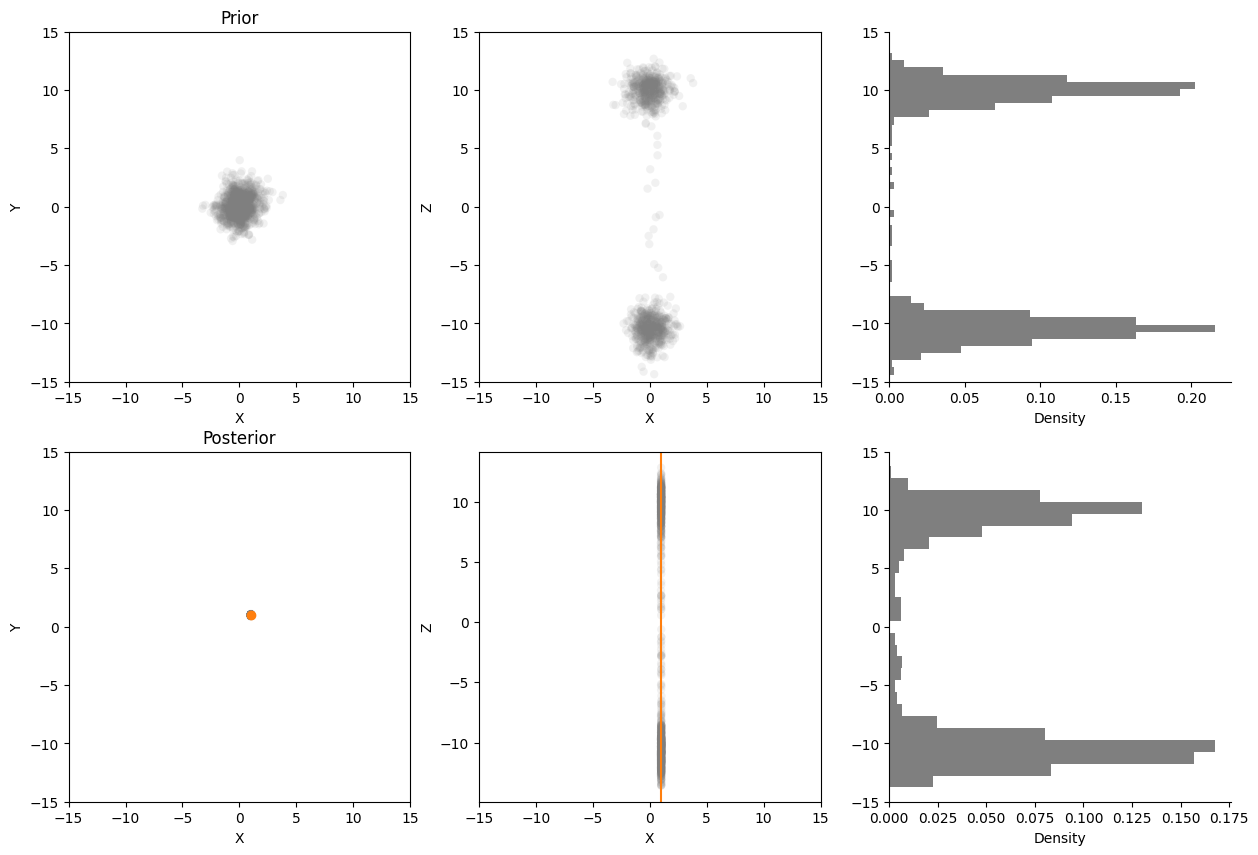

In [40]:
M_prior = flow.sample(1000, prior_data)['x']['x'].detach()
M_posterior = flow.sample(1000, posterior_data)['x']['x'].detach()

plt.style.use('default')
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].scatter(M_prior[..., 0], M_prior[..., 1], c='tab:gray', alpha=0.1, edgecolor='none')
axs[0, 0].set_xlim(-15, 15)
axs[0, 0].set_ylim(-15, 15)
axs[0, 0].set_title('Prior')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')

axs[0, 1].scatter(M_prior[..., 0], M_prior[..., 2], c='tab:gray', alpha=0.1, edgecolor='none')
axs[0, 1].set_xlim(-15, 15)
axs[0, 1].set_ylim(-15, 15)
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Z')

axs[1, 0].scatter(M_posterior[..., 0], M_posterior[..., 1], c='tab:gray', alpha=0.1, edgecolor='none')
axs[1, 0].scatter([1], [1], c='tab:orange')
axs[1, 0].set_xlim(-15, 15)
axs[1, 0].set_ylim(-15, 15)
axs[1, 0].set_title('Posterior')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')

axs[1, 1].scatter(M_posterior[..., 0], M_posterior[..., 2], c='tab:gray', alpha=0.1, edgecolor='none')
axs[1, 1].axvline(1, c='tab:orange')
axs[1, 1].set_xlim(-15, 15)
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Z')

axs[1, 2].hist(M_posterior[..., 2].detach(), bins=np.linspace(-25, 25, 50), orientation='horizontal', density=True, color='tab:gray')
axs[1, 2].set_ylim(-15, 15)
axs[1, 2].set_xlabel('Density')
sns.despine(ax=axs[1, 2])

axs[0, 2].hist(M_prior[..., 2].detach(), bins=np.linspace(-15, 15, 50), orientation='horizontal', density=True, color='tab:gray')
axs[0, 2].set_ylim(-15, 15)
axs[0, 2].set_xlabel('Density')
sns.despine(ax=axs[0, 2])



# Two Points

In [3]:
class TwoPointDataset(Dataset):
    def __init__(self, n_items_full=100, n_items_subset=100, prior=None):
        if prior is None:
            prior = D.MultivariateNormal(torch.zeros(3), torch.eye(3))

        data_list = []

        for i in range(n_items_full):
            data = HeteroData()

            direction = torch.randn(1, 1, 3)
            direction[..., 2] = torch.randn(1, 1) / 5
            direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1)

            M1 = prior.sample((1,))
            M2 = (M1 + direction).squeeze(0)

            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['c'].x = data['x'].x[..., :2]

            data['c', '->', 'x'].edge_index = torch.LongTensor([[0, 0], [1, 1]]).T
            data['x', '<->', 'x'].edge_index = torch.LongTensor([[0, 1], [1, 0]]).T
            data_list.append(data)

        for i in range(n_items_subset // 2):
            data = HeteroData()

            direction = torch.randn(1, 1, 3)
            direction[..., 2] = torch.randn(1, 1) / 5
            direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1)

            M1 = prior.sample((1,))
            M2 = (M1 + direction).squeeze(0)

            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['c'].x = data['x'].x[..., :2][0].unsqueeze(0)

            data['c', '->', 'x'].edge_index = torch.LongTensor([[0, 0]]).T
            data['x', '<->', 'x'].edge_index = torch.LongTensor([[0, 1], [1, 0]]).T
            data_list.append(data)

            data = HeteroData()

            direction = torch.randn(1, 1, 3)
            direction[..., 2] = torch.randn(1, 1) / 5
            direction = direction / torch.norm(direction, dim=-1).unsqueeze(-1)

            M1 = prior.sample((1,))
            M2 = (M1 + direction).squeeze(0)

            data['x'].x = torch.stack([M1, M2]).squeeze()
            data['c'].x = data['x'].x[..., :2][1].unsqueeze(0)

            data['c', '->', 'x'].edge_index = torch.LongTensor([[0, 1]]).T
            data['x', '<->', 'x'].edge_index = torch.LongTensor([[0, 1], [1, 0]]).T
            data_list.append(data)

        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def metadata(self):
        return self.data[0].metadata()

In [13]:
dataset = TwoPointDataset(n_items_full=1000, n_items_subset=2000)
data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

In [22]:
epochs = 200
lr = 0.001
weight_decay = 1e-5

flow = CondGraphFlow(num_layers=10)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)

In [23]:
supervised_trainer(data_loader, flow, optimizer, epochs=epochs)


Epoch: 1/100 | RegPriorLoss 4.7686 | RegPosteriorLoss 3.1977 | Batch: 100%|██████████| 30/30 [00:04<00:00,  6.66it/s]
Epoch: 2/100 | RegPriorLoss 4.5940 | RegPosteriorLoss 2.6482 | Batch: 100%|██████████| 30/30 [00:04<00:00,  6.80it/s]
Epoch: 3/100 | RegPriorLoss 4.3433 | RegPosteriorLoss 2.3497 | Batch: 100%|██████████| 30/30 [00:04<00:00,  6.53it/s]
Epoch: 4/100 | RegPriorLoss 4.5636 | RegPosteriorLoss 1.9173 | Batch: 100%|██████████| 30/30 [00:04<00:00,  6.73it/s]
Epoch: 5/100 | RegPriorLoss 4.4857 | RegPosteriorLoss 1.5668 | Batch: 100%|██████████| 30/30 [00:04<00:00,  6.72it/s]
Epoch: 6/100 | RegPriorLoss 4.1955 | RegPosteriorLoss 1.1333 | Batch: 100%|██████████| 30/30 [00:05<00:00,  5.78it/s]
Epoch: 7/100 | RegPriorLoss 4.2018 | RegPosteriorLoss 0.8352 | Batch: 100%|██████████| 30/30 [00:04<00:00,  6.72it/s]
Epoch: 8/100 | RegPriorLoss 3.7386 | RegPosteriorLoss 0.3051 | Batch: 100%|██████████| 30/30 [00:04<00:00,  6.89it/s]
Epoch: 9/100 | RegPriorLoss 3.9089 | RegPosteriorLoss 0.

In [24]:
posterior_data = HeteroData({
    'x': {'x': torch.zeros(2, 1, 3), 'batch': torch.Tensor([0, 1])},
    'c': {'x': torch.Tensor([[2, 2], [1, 2]]), 'batch': torch.Tensor([0, 1])},
    ('x', '<->', 'x'): { 'edge_index' : torch.LongTensor([[0, 1], [1, 0]]).T },
    ('c',  '->', 'x'): { 'edge_index': torch.LongTensor([[0, 0], [1, 1]]).T }
})

part_data = HeteroData({
    'x': {'x': torch.zeros(2, 1, 3), 'batch': torch.Tensor([0, 1])},
    'c': {'x': torch.Tensor([[0, 0]]), 'batch': torch.Tensor([0])},
    ('x', '<->', 'x'): { 'edge_index' : torch.LongTensor([[0, 1], [1, 0]]).T },
    ('c',  '->', 'x'): { 'edge_index': torch.LongTensor([[0, 0]]).T }
})

prior_data = HeteroData({
    'x': {'x': torch.zeros(2, 1, 3), 'batch': torch.Tensor([0, 1])},
    ('x', '<->', 'x'): { 'edge_index' : torch.LongTensor([[0, 1], [1, 0]]).T },
})

In [25]:
M_prior = flow.sample(1000, prior_data)['x']['x'].detach()
M_posterior = flow.sample(1000, posterior_data)['x']['x'].detach()
M_part = flow.sample(1000, part_data)['x']['x'].detach().squeeze()

prior_dist = torch.norm(M_prior[0] - M_prior[1], dim=-1)
posterior_dist = torch.norm(M_posterior[0] - M_posterior[1], dim=-1)
part_dist = torch.norm(M_part[0] - M_part[1], dim=-1)

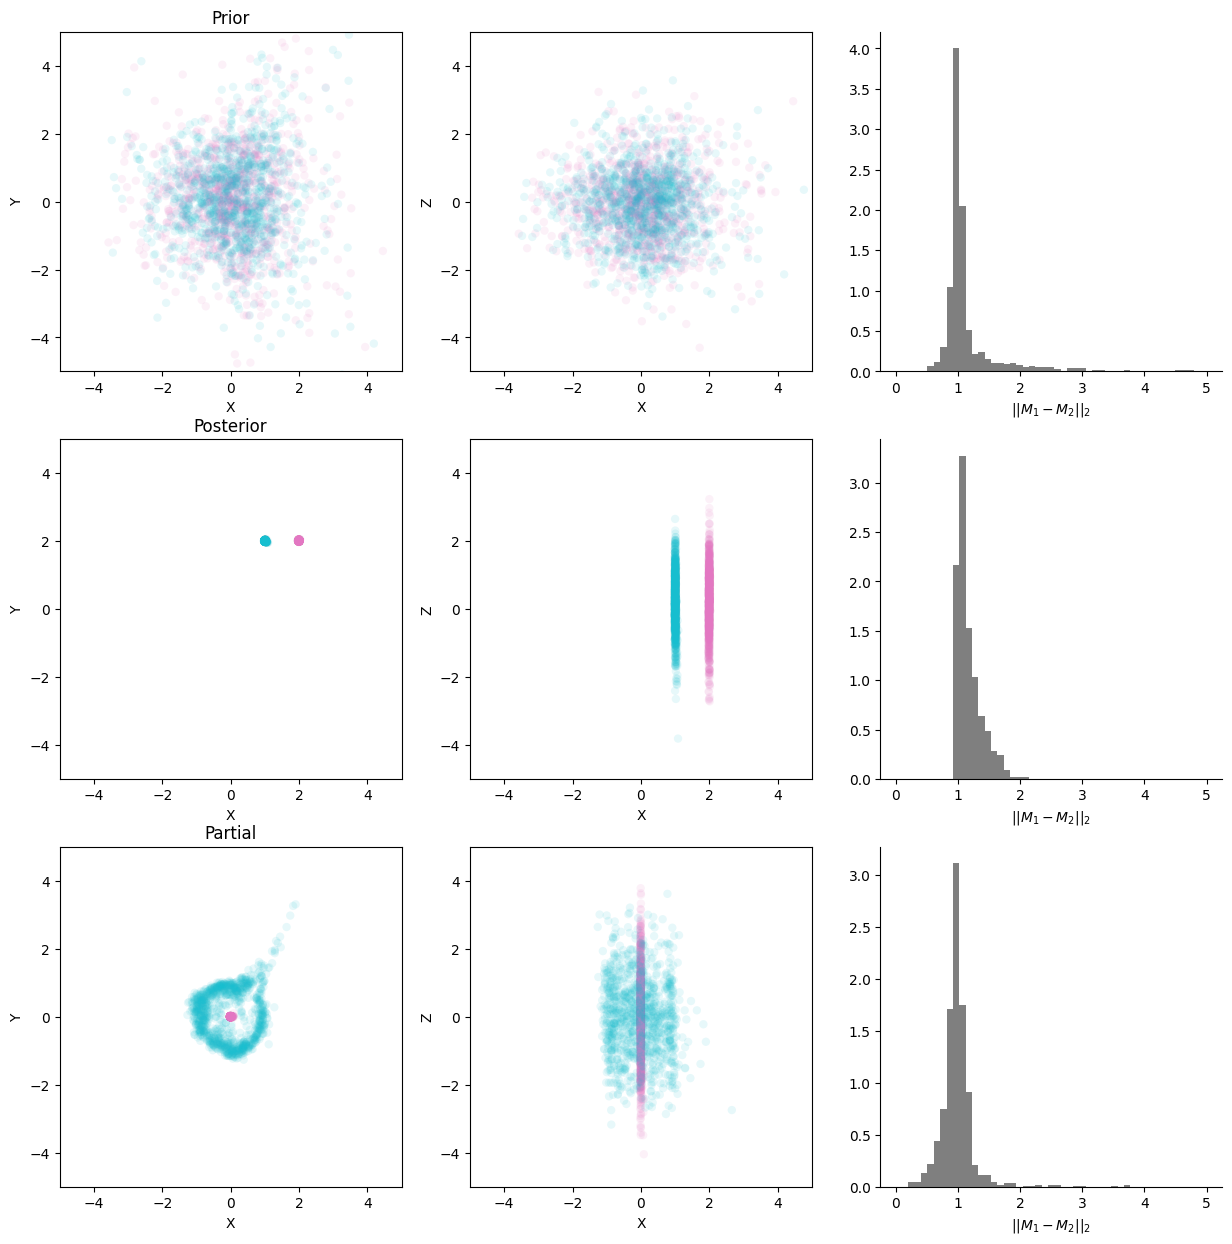

In [26]:
plt.style.use('default')
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].scatter(M_prior[0, :, 0], M_prior[0, :, 1], c='tab:pink', alpha=0.1, edgecolor='none')
axs[0, 0].scatter(M_prior[1, :, 0], M_prior[1, :, 1], c='tab:cyan', alpha=0.1, edgecolor='none')
axs[0, 0].set_xlim(-5, 5)
axs[0, 0].set_ylim(-5, 5)
axs[0, 0].set_title('Prior')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')

axs[0, 1].scatter(M_prior[0, :, 0], M_prior[0, :, 2], c='tab:pink', alpha=0.1, edgecolor='none')
axs[0, 1].scatter(M_prior[1, :, 0], M_prior[1, :, 2], c='tab:cyan', alpha=0.1, edgecolor='none')
axs[0, 1].set_xlim(-5, 5)
axs[0, 1].set_ylim(-5, 5)
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Z')

axs[1, 0].scatter(M_posterior[0, :, 0], M_posterior[0, :, 1], c='tab:pink', alpha=0.1, edgecolor='none')
axs[1, 0].scatter(M_posterior[1, :, 0], M_posterior[1, :, 1], c='tab:cyan', alpha=0.1, edgecolor='none')
axs[1, 0].set_xlim(-5, 5)
axs[1, 0].set_ylim(-5, 5)
axs[1, 0].set_title('Posterior')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')

axs[1, 1].scatter(M_posterior[0, :, 0], M_posterior[0, :, 2], c='tab:pink', alpha=0.1, edgecolor='none')
axs[1, 1].scatter(M_posterior[1, :, 0], M_posterior[1, :, 2], c='tab:cyan', alpha=0.1, edgecolor='none')
axs[1, 1].set_xlim(-5, 5)
axs[1, 1].set_ylim(-5, 5)
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Z')

axs[2, 0].scatter(M_part[0, :, 0], M_part[0, :, 1], c='tab:pink', alpha=0.1, edgecolor='none', zorder=10)
axs[2, 0].scatter(M_part[1, :, 0], M_part[1, :, 1], c='tab:cyan', alpha=0.1, edgecolor='none')
axs[2, 0].set_xlim(-5, 5)
axs[2, 0].set_ylim(-5, 5)
axs[2, 0].set_title('Partial')
axs[2, 0].set_xlabel('X')
axs[2, 0].set_ylabel('Y')


axs[2, 1].scatter(M_part[0, :, 0], M_part[0, :, 2], c='tab:pink', alpha=0.1, edgecolor='none')
axs[2, 1].scatter(M_part[1, :, 0], M_part[1, :, 2], c='tab:cyan', alpha=0.1, edgecolor='none')
axs[2, 1].set_xlim(-5, 5)
axs[2, 1].set_ylim(-5, 5)
axs[2, 1].set_xlabel('X')
axs[2, 1].set_ylabel('Z')

axs[0, 2].hist(prior_dist.unsqueeze(0), bins=np.linspace(0, 5, 50), density=True, color='tab:gray')
axs[0, 2].set_xlabel('$||M_1 - M_2||_2$')

axs[1, 2].hist(posterior_dist.unsqueeze(0), bins=np.linspace(0, 5, 50), density=True, color='tab:gray')
axs[1, 2].set_xlabel('$||M_1 - M_2||_2$')

axs[2, 2].hist(part_dist.unsqueeze(0), bins=np.linspace(0, 5, 50), density=True, color='tab:gray')
axs[2, 2].set_xlabel('$||M_1 - M_2||_2$')

sns.despine(ax=axs[0, 2])
sns.despine(ax=axs[1, 2])
sns.despine(ax=axs[2, 2])
